In [82]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchinfo import summary
from sklearn.metrics import precision_score, recall_score, f1_score

from tqdm import tqdm
import wandb
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Suppress specific warning (the UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


In [ ]:
train_dir = r"\K_OCR\train"
test_dir = r"\K_OCR\test"

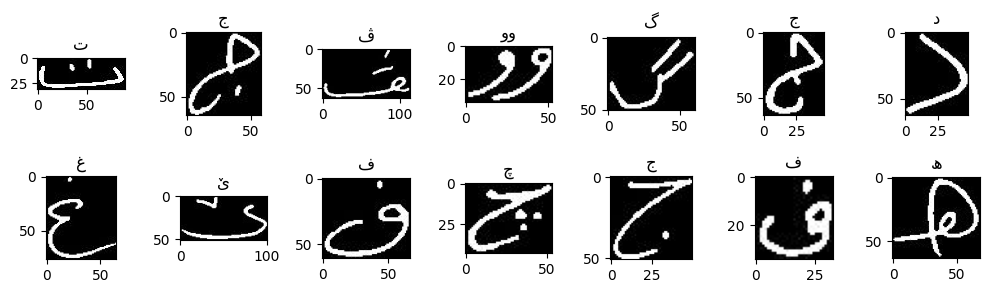

In [181]:
plt.figure(figsize=(10,10))
for i in range(1, 15):
    random_model = np.random.choice(os.listdir(train_dir))
    model_path = os.path.join(train_dir, random_model)
    random_img = np.random.choice(os.listdir(model_path))
    img_path = os.path.join(model_path, random_img)
    img = Image.open(img_path)
    
    plt.subplot(7,7, i)
    plt.imshow(img, cmap='gray')
    plt.title(random_model)

plt.tight_layout()
plt.show()

In [4]:
class cnn_model(nn.Module):
    def __init__(self, in_channels, num_classes=34):
        super().__init__()

        self.conv2d1 = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2d2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu2 = nn.ReLU()
        # self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(16 * 7* 7, num_classes)

    def forward(self, x):
        x = self.conv2d1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2d2(x)
        x = self.relu1(x)
        x = self.pool2(x)

        x = self.relu2(x)
        x = x.reshape(x.shape[0], -1)
        # x = x.View(x.size(0), -1)

        x = self.fc1(x)
        return x

In [5]:
model = cnn_model(in_channels=1, num_classes=34)
summary(model)

Layer (type:depth-idx)                   Param #
cnn_model                                --
├─Conv2d: 1-1                            80
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            1,168
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─ReLU: 1-7                              --
├─Linear: 1-8                            26,690
Total params: 27,938
Trainable params: 27,938
Non-trainable params: 0

In [ ]:
train_transform_pipe = transforms.Compose(
    [
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Grayscale(),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.5),
    ]
)

test_transform_pipe = transforms.Compose(
    [
        transforms.Resize((28, 28)),
        transforms.ToTensor(),
        transforms.Grayscale(),
        
    ]
)

def get_data(dataset_dir, transform):
    norm_dataset_train  = datasets.ImageFolder(dataset_dir, transform = transform)
    return norm_dataset_train

def make_loader(dataset, batch_size):
    loader = DataLoader(dataset,batch_size=batch_size,shuffle=True)
    return loader

def train_log(train_loss,train_accuracy,val_loss, val_accuracy,precision, recall, f1, example_ct, epoch):
    wandb.log({"epoch": epoch, "train_loss": train_loss,
                "train_accuracy": train_accuracy,
                "val_loss": val_loss,
                "val_accuracy": val_accuracy,
                "precision": precision,
                "recall": recall,
                  "f1_score": f1
                },step=example_ct)


    print(f"Loss after {str(example_ct).zfill(5)} train_loss: {train_loss:.3f},train_accuracy: {train_accuracy:.3f},val_loss: {val_loss:.3f},val_accuracy: {val_accuracy:.3f} ")


In [141]:
def compute_metrics(y, ypred):
    precision = precision_score(y, ypred, average='macro')
    recall = recall_score(y, ypred, average='macro')
    f1 = f1_score(y, ypred, average='macro')
    return precision, recall, f1

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, config):
    wandb.watch(model, criterion, log="all", log_freq=10)
    # Important, don't change this!

    total_batches = len(train_loader) * config.epochs
    example_ct = 0  # number of examples seen
    batch_ct = 0
    train_loss = []
    val_loss = []
    for epoch in range(config.epochs):
        train_accuracy,  epoch_loss= 0, 0
        val_epoch_loss, val_accuracy = 0, 0
        precision, recall, f1= 0,0,0
        for images, labels in tqdm(train_loader, desc="Training", leave=False):
            # Forward pass
            ytrain = model(images)
            loss = criterion(ytrain, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Step with optimizer
            optimizer.step()

            example_ct +=  len(images)
            batch_ct += 1

            epoch_loss += loss.item()
            
            Tcorrect = torch.eq(torch.argmax(ytrain, dim=1), labels)
            # train_accuracy += torch.sum(Tcorrect).item()
            train_accuracy += Tcorrect.sum().item()
            
        
        average_train_loss = epoch_loss / len(train_loader)
        train_loss.append(average_train_loss)
        train_accuracy /= len(train_loader.dataset)

                
        model.eval()
        with torch.no_grad():
            for xval, yval in tqdm(val_loader, desc="pridicting", leave=False):
                yprobs = model(xval)
                loss_evaluate = criterion(yprobs, yval)

                val_epoch_loss += loss_evaluate.item()
                ypred_val = torch.argmax(yprobs, dim=1)
                Vcorrect = torch.eq(ypred_val, yval)

                metrics = compute_metrics(yval, ypred_val)
                precision+= metrics[0]
                recall += metrics[1]
                f1 += metrics[2]

                # val_accuracy += torch.sum(Vcorrect).item() # or Vcorrect.sum().item()
                val_accuracy += Vcorrect.sum().item()
            precision /= len(val_loader)
            recall /= len(val_loader)
            f1 /= len(val_loader)
            
            avg_val_loss = val_epoch_loss / len(val_loader) # not len(val_loader.dataset), batch-wise method is used
            val_loss.append(avg_val_loss)
            val_accuracy /= len(val_loader.dataset)   # not len(val_loader), due to using sample-wise method
        # Report metrics every 10th batch
        if ((epoch+1) % 10) == 0:
            train_log(average_train_loss,train_accuracy ,avg_val_loss,val_accuracy,precision, recall, f1, example_ct, epoch)


In [ ]:
def test(model, test_loader):
    model.eval()

    # Run the model on some test examples
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        correct, total = 0, 0
        for images, labels in tqdm(test_loader, desc="Infrencing", leave=False): 
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.append(labels)
            all_predictions.append(predicted)
        
        all_labels = np.concatenate(all_labels)  # Flatten to 1D array
        all_predictions = np.concatenate(all_predictions)

        test_accuracy = correct / total
        precision, recall, f1 = compute_metrics(labels, predicted)

        print(f"Accuracy of the model on the {total} " +
              f"test images: {test_accuracy:%}")
        
        
        wandb.log({"test_accuracy": test_accuracy, "precision":precision, "recall": recall, "f1-score": f1 })

    torch.save(model.state_dict(), "model.pth")

    # Save the model in the exchangeable format
    artifact = wandb.Artifact("best_model", type="model")
    artifact.add_file("model.pth")
    wandb.log_artifact(artifact)

In [144]:
config = dict(
    epochs=100,
    classes=34,
    # kernels=[16, 32],
    batch_size=32,
    learning_rate=0.001,
    dataset="Kurdish_chars",
    architecture="CNN")

In [145]:
def make(config):
    # Make the data
    train, test = get_data(train_dir,transform=train_transform_pipe), get_data(test_dir, transform=test_transform_pipe)
    g = torch.Generator()
    g.manual_seed(42)
    train, val = random_split(train, [0.8, 0.2], generator = g)

    train_loader = make_loader(train, batch_size=config.batch_size)
    val_loader = make_loader(val, batch_size=config.batch_size)
    test_loader = make_loader(test, batch_size=config.batch_size)
    
    # Make the model
    model = cnn_model(in_channels=1, num_classes=34)

    model = cnn_model(in_channels=1, num_classes=34)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = config.learning_rate)
    
 
    return model, train_loader,val_loader, test_loader, criterion, optimizer

In [146]:
def model_pipeline(hyperparameters):

    with wandb.init(project="pytorch-demo", config=hyperparameters):
      config = wandb.config

      model, train_loader,val_loader, test_loader, criterion, optimizer = make(config)
      print(model)

      train(model, train_loader,val_loader, criterion, optimizer, config)

      test(model, test_loader)

    return model

In [ ]:
model = model_pipeline(config)


cnn_model(
  (conv2d1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
  (fc1): Linear(in_features=784, out_features=34, bias=True)
)
                                                           
Loss after 24760 train_loss: 0.986,train_accuracy: 0.710,val_loss: 1.234,val_accuracy: 0.629 
                                                           
Loss after 49520 train_loss: 0.672,train_accuracy: 0.801,val_loss: 1.080,val_accuracy: 0.673 
                                                           
Loss after 74280 train_loss: 0.515,train_accuracy: 0.843,val_loss: 1.125,val_accuracy: 0.699 
                                                           
Loss after 99040 train_l

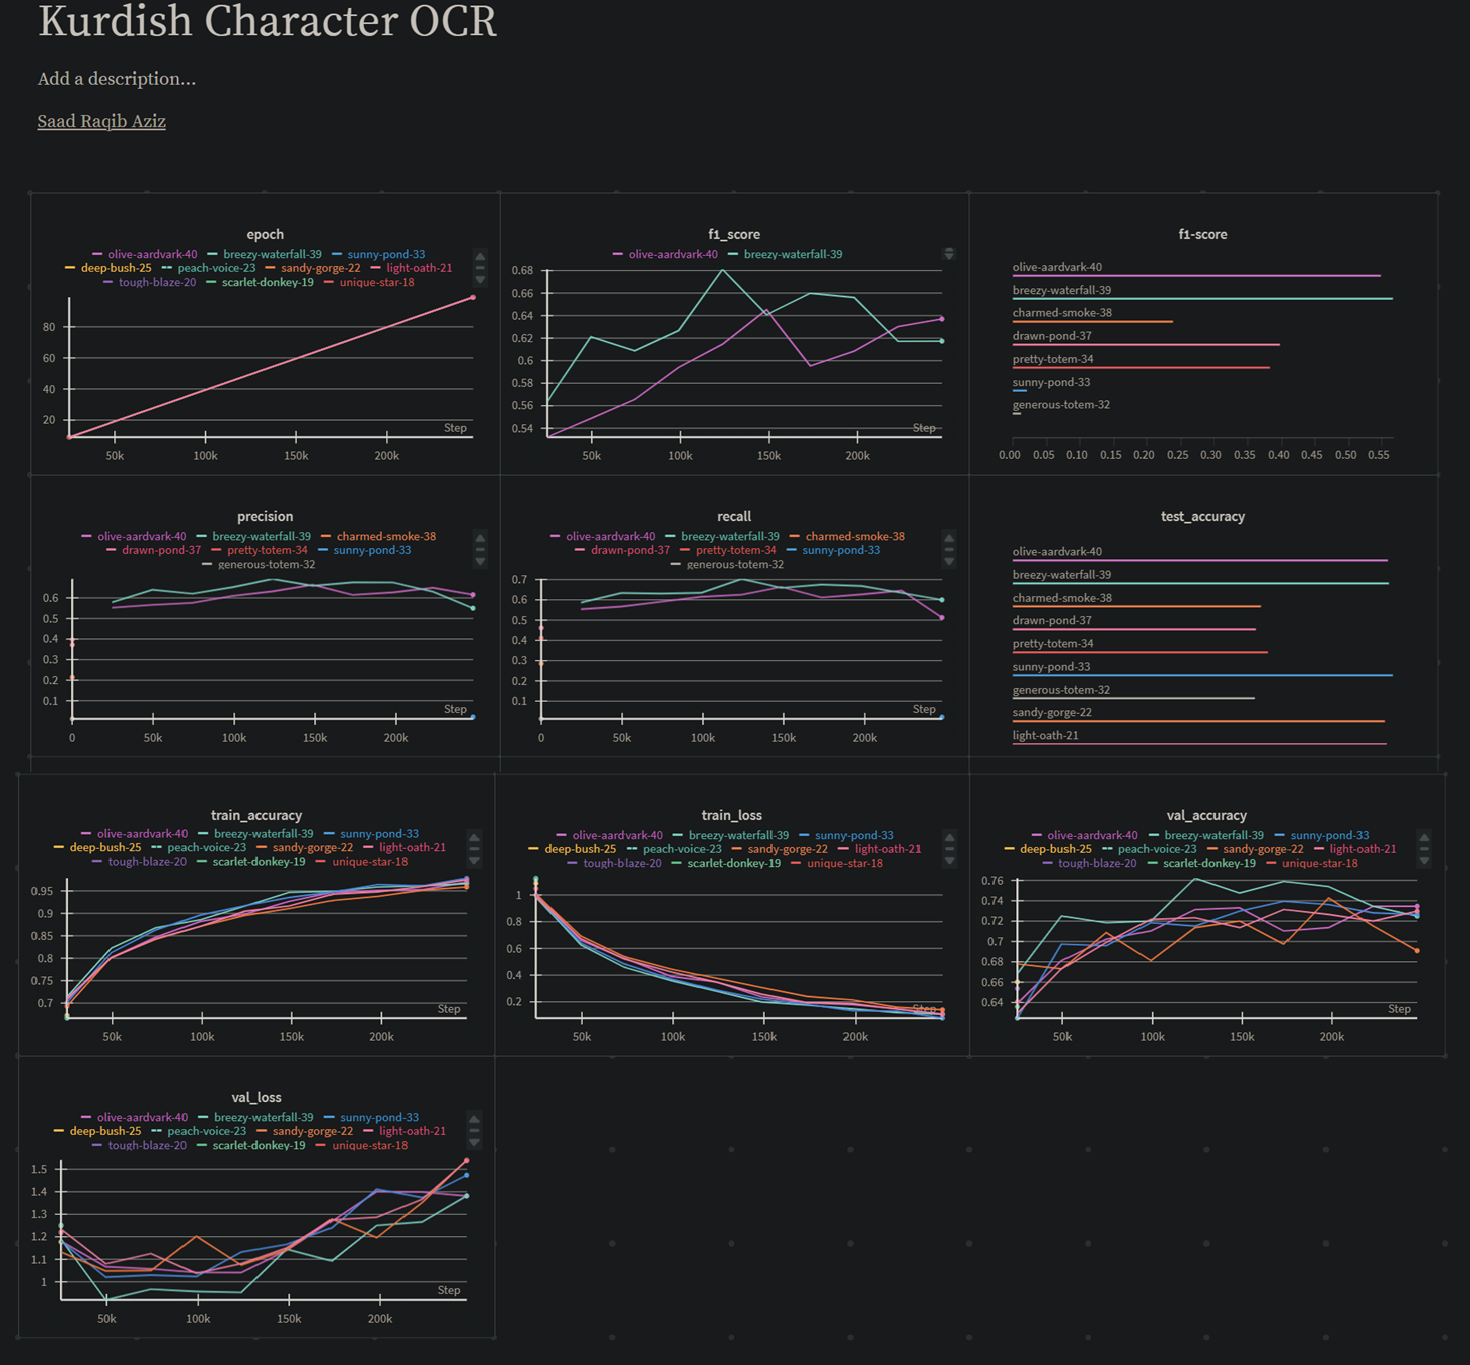

In [183]:
test_dataset = get_data(test_dir, transform=test_transform_pipe)
test_loader = make_loader(test_dataset, 32)

In [184]:
class_to_idx = test_dataset.class_to_idx
idx_to_class = {v:k for k, v in class_to_idx.items()}
print(idx_to_class)

{0: 'ئـ', 1: 'ا', 2: 'ب', 3: 'ت', 4: 'ج', 5: 'ح', 6: 'خ', 7: 'د', 8: 'ر', 9: 'ز', 10: 'س', 11: 'ش', 12: 'ع', 13: 'غ', 14: 'ف', 15: 'ق', 16: 'ل', 17: 'م', 18: 'ن', 19: 'و', 20: 'وو', 21: 'پ', 22: 'چ', 23: 'ڕ', 24: 'ژ', 25: 'ڤ', 26: 'ک', 27: 'گ', 28: 'ڵ', 29: 'ھ', 30: 'ۆ', 31: 'ی', 32: 'ێ', 33: 'ە'}


Actual Char:  ئـ
predicted Char:  ئـ


c:\Users\saadr\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\_tensor.py:889: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


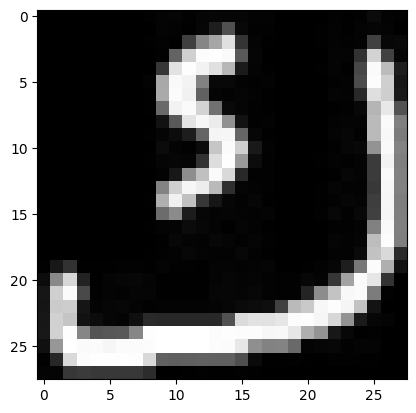

In [185]:
batch = next(iter(test_loader))
img = batch[0][0].reshape((28,28))
label = batch[1][0]
probs = model(img.resize(1,1,28,28))
predicted_index = torch.argmax(probs)
print("Actual Char: ", idx_to_class[int(label)])
print("predicted Char: ", idx_to_class[int(predicted_index)])
plt.imshow(img,cmap='gray')